In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR

from tqdm import tqdm_notebook
from itertools import product
from typing import Union

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

## Load data

In [ ]:
# load dataset
dataframe = pd.read_csv('FEDFUNDS.csv',
                        index_col='DATE',
                        dtype={'FEDFUNDS': np.float32},
                        parse_dates=True,
                        date_parser=lambda date: datetime.strptime(date, '%Y-%m-%d'),
                       )

dataframe.head()

,FEDFUNDS
DATE,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83


In [ ]:
# create a time series
st = pd.Series(dataframe.unstack().values, index=dataframe.index)

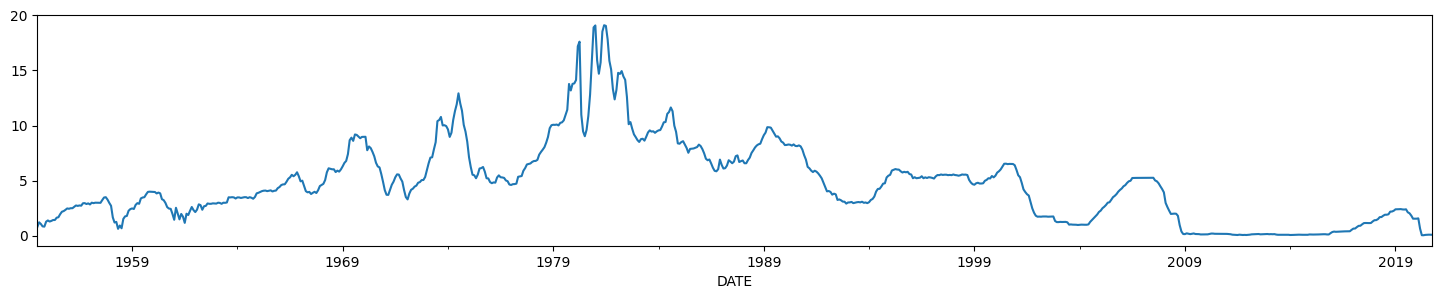

In [ ]:
# basic plot
st.plot();

## Prueba de estacionariedad


In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, significance_level=0.05):

    """
    Realiza la prueba de Dickey-Fuller Aumentada en una serie de tiempo dada y evalúa su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser probados.
    significance_level (float): El nivel de significancia para la prueba (por defecto es 0.05).

    retorna:
    dict: Un diccionario que contiene el estadístico ADF, el valor p, los valores críticos y si la serie es estacionaria.

    """
    dftest = adfuller(timeseries)
    adf_statistic, p_value, used_lag, nobs, critical_values, icbest = dftest

    # Determinar si la serie es estacionaria basado en el valor p y el estadístico ADF
    is_stationary_p = p_value < significance_level
    is_stationary_adf = adf_statistic < critical_values['5%']  # Utiliza el valor crítico al 5%
    is_stationary = is_stationary_p and is_stationary_adf

    return {
        "ADF Statistic": adf_statistic,
        "p-value": p_value,
        "Critical Values": critical_values,
        "Is Stationary (p-value)": is_stationary_p,
        "Is Stationary (ADF)": is_stationary_adf,
        "Is Stationary (Both)": is_stationary
    }



adf_test_results = test_stationarity(st)
adf_test_results

{'ADF Statistic': -2.627979544419555,
 'p-value': 0.08735123975141307,
 'Critical Values': {'1%': -3.438783171038672,
  '5%': -2.865262118650577,
  '10%': -2.568752018688748},
 'Is Stationary (p-value)': False,
 'Is Stationary (ADF)': False,
 'Is Stationary (Both)': False}

### Estacionalización una serie de tiempo
mediante diferenciación recurrente y verifica su estacionariedad.

In [ ]:
def make_stationary_recursive(time_series, significance_level=0.05, max_diff=10):
    """
    Estacionaliza una serie de tiempo mediante diferenciación recurrente y
    verifica su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser procesados.
    significance_level (float): El nivel de significancia para la prueba ADF (por defecto es 0.05).
    max_diff (int): El número máximo de diferenciaciones a aplicar.

    Retorna:
    tuple: Una tupla conteniendo el número de diferenciaciones aplicadas (d),
           la serie de tiempo diferenciada y los resultados de la prueba ADF.
    """
    d = 0  # Contador de diferenciaciones
    diff_series = time_series.copy()

    for i in range(max_diff):
        adf_test_results = test_stationarity(diff_series, significance_level)
        if adf_test_results['Is Stationary (Both)']:
            break
        else:
            diff_series = diff_series.diff().dropna()
            d += 1

    return d, diff_series, adf_test_results

In [ ]:
d_count, diff_series, adf_results = make_stationary_recursive(st)
d_count, adf_results

(1,
 {'ADF Statistic': -6.213246942335152,
  'p-value': 5.442947981923038e-08,
  'Critical Values': {'1%': -3.438804978547988,
   '5%': -2.8652717302548396,
   '10%': -2.5687571389759802},
  'Is Stationary (p-value)': True,
  'Is Stationary (ADF)': True,
  'Is Stationary (Both)': True})

## Train-Test Split

In [ ]:
# Separando la serie de tiempo diferenciada en conjuntos de entrenamiento y prueba
train_size = int(len(diff_series) * 0.4)
train, test = diff_series[:train_size], diff_series[train_size:]

len(train), len(test)

(318, 477)

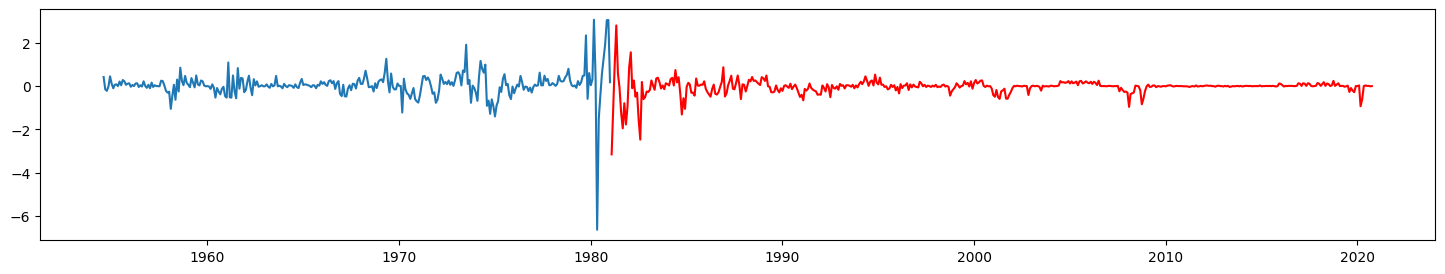

In [ ]:
# plot train-test split of time series data
plt.plot(train)
plt.plot(test, color='r');

## Prueba de autocorrelación (ACF) y autocorrelacion parcial (PACF)

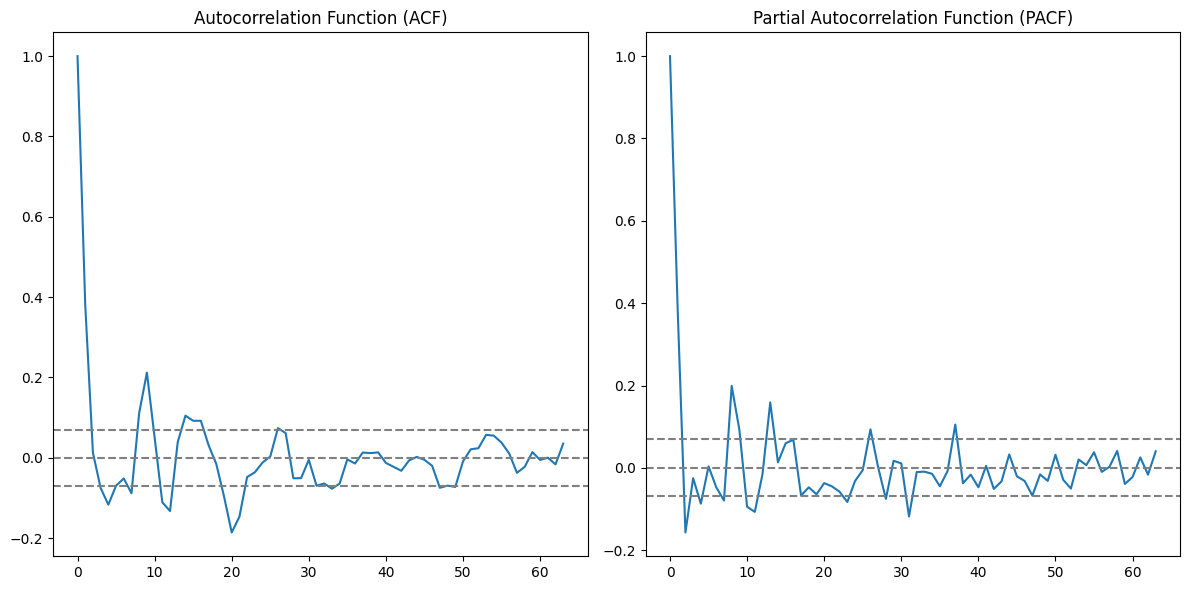

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

vnlag=min(100, len(train)//5)
lag_acf = acf(diff_series, nlags=vnlag)
lag_pacf = pacf(diff_series, nlags=vnlag, method='ols')

# Plotting ACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')

# Plotting PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()

plt.show()

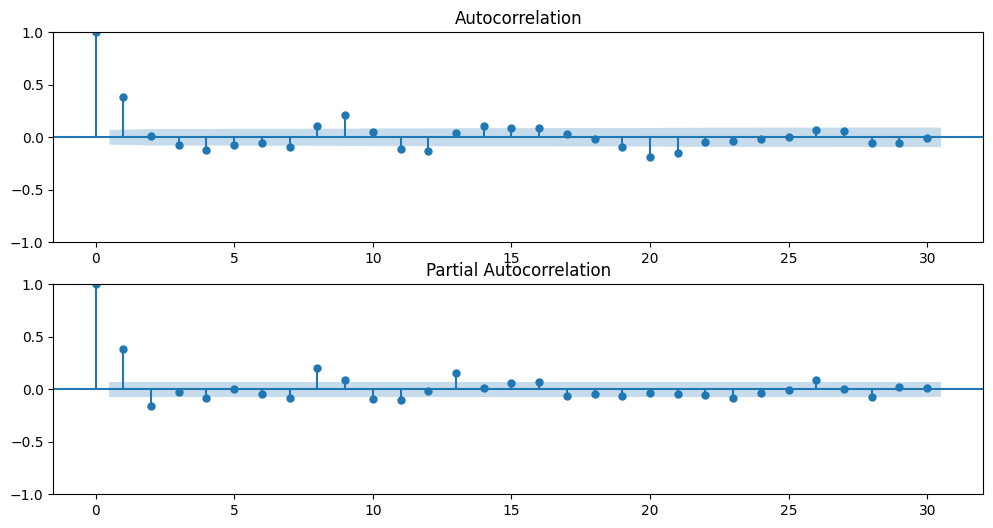

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplots(figsize=(12, 6))
plt.subplot(211)
plot_acf(diff_series, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff_series, ax=plt.gca())
plt.show()

## Modelo ARIMA

In [ ]:
from typing import Union
from tqdm import tqdm_notebook
from itertools import product

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = ARIMA(endog, order=(order[0], d, order[1])).fit()
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


ps = range(0, 10, 1)
qs = range(0, 10, 1)
#ps =[1, 2,8, 9,10, 11]
#qs=[1,4,7,8,9,11,12,20,21]
d = 0

order_list = list(product(ps, qs))

result_df = optimize_ARIMA(train, order_list, d)
print(result_df)

  0%|          | 0/100 [00:00<?, ?it/s]

     (p,q)    AIC
0   (2, 8) 556.10
1   (7, 1) 556.70
2   (3, 8) 557.21
3   (2, 9) 557.43
4   (8, 4) 557.52
..     ...    ...
95  (1, 3) 584.24
96  (3, 1) 584.34
97  (2, 2) 584.54
98  (5, 2) 584.84
99  (0, 0) 620.72

[100 rows x 2 columns]


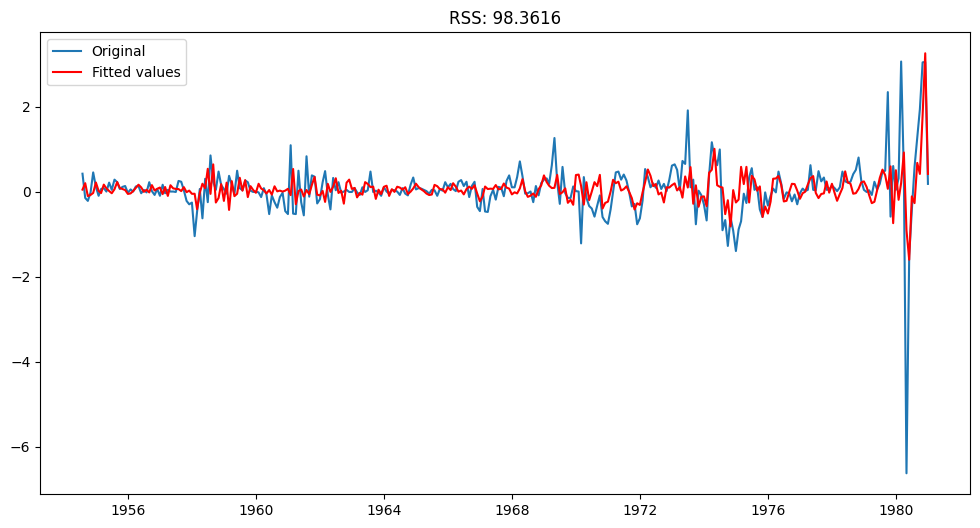

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  318
Model:                 ARIMA(2, 0, 8)   Log Likelihood                -266.048
Date:                Fri, 26 Apr 2024   AIC                            556.095
Time:                        13:48:28   BIC                            601.240
Sample:                    08-01-1954   HQIC                           574.126
                         - 01-01-1981                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0454      0.051      0.883      0.377      -0.055       0.146
ar.L1          1.2356      0.066     18.653      0.000       1.106       1.365
ar.L2         -0.6787      0.064    -10.574      0.0

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Ajustando el modelo ARIMA
model = ARIMA(train, order=(2, 0, 8))
results = model.fit()

# Visualización de la serie de entrenamiento y los valores ajustados
plt.figure(figsize=(12, 6))
plt.plot(train, label='Original')
plt.plot(results.fittedvalues, color='red', label='Fitted values')
plt.title('RSS: %.4f' % sum((results.fittedvalues - train)**2))
plt.legend()
plt.show()

print(results.summary())

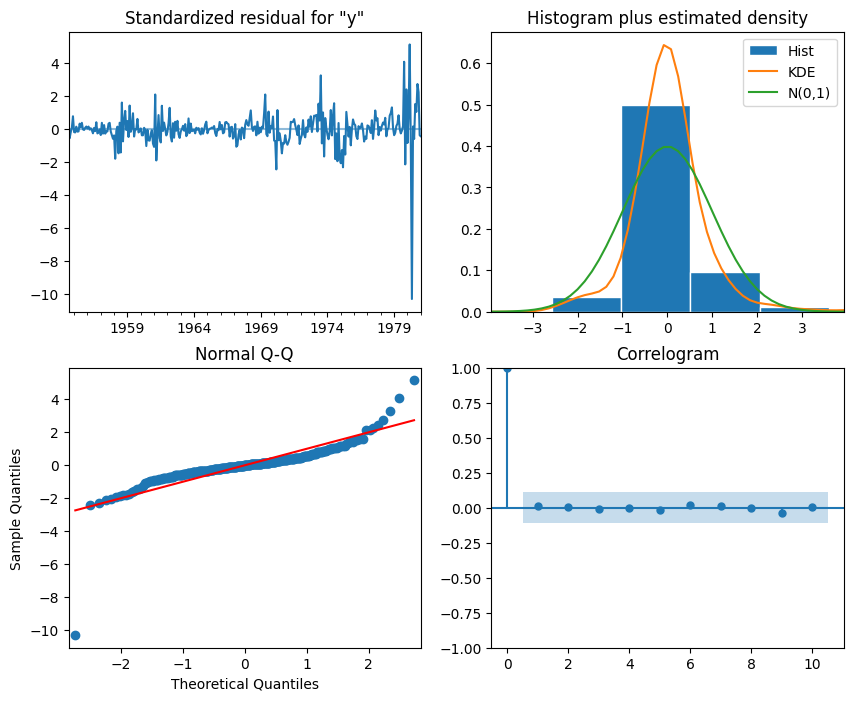

In [ ]:
results.plot_diagnostics(figsize=(10,8));

## Predicción

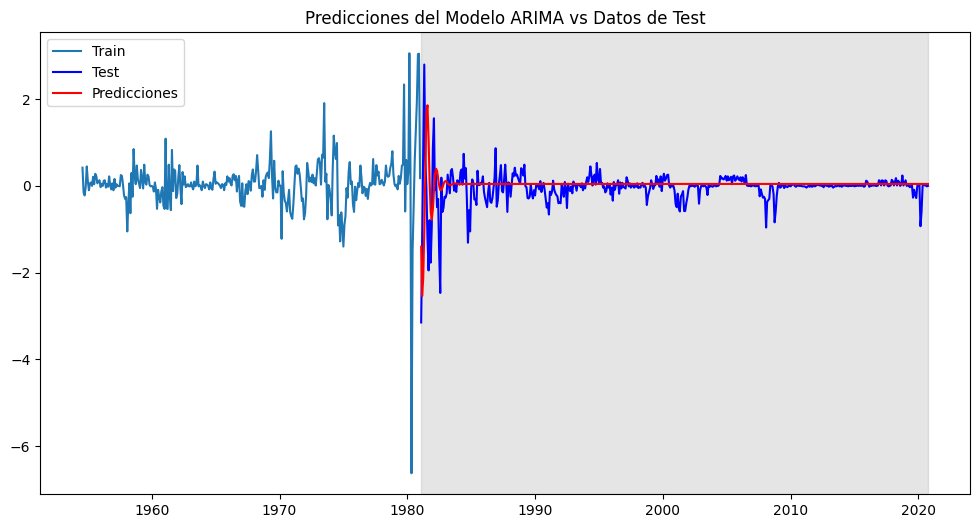

(0.19241635293412496, 0.43865288433352967)

In [ ]:
predictions = results.get_forecast(steps=len(test))
predicted_mean = predictions.predicted_mean

# Convertir las predicciones a una serie para facilitar la comparación
predicted_series = pd.Series(predicted_mean, index=test.index)

# Visualización de las predicciones y los datos de prueba
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train, label='Train')
ax.plot(test, label='Test', color='blue')
ax.plot(predicted_series, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo ARIMA vs Datos de Test')

fecha_inicio = test.index[0]
fecha_fin = test.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)

plt.show()

mse = mean_squared_error(test, predicted_series)
rmse = np.sqrt(mse)

mse, rmse

In [ ]:
def rolling_forecast(df, train_len, horizon: int, window: int, order: list):

    total_len = train_len + horizon
    pred_ARIMA = []
    pred_ARIMA_2 = []

    for i in tqdm_notebook(range(train_len, total_len, window)):
        model = ARIMA(df[:i], order=order)
        res = model.fit()
        predictions = res.forecast(window)
        pred_ARIMA.extend(predictions)

    return pred_ARIMA

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 8
pred_ARIMA = rolling_forecast(diff_series, TRAIN_LEN, HORIZON, WINDOW, (2,0,8))
fechas = test.index
st_pred_ARIMA = pd.Series(pred_ARIMA[:len(fechas)], index=fechas)

mse = mean_squared_error(test, st_pred_ARIMA)
rmse = np.sqrt(mse)

mse, rmse

  0%|          | 0/60 [00:00<?, ?it/s]

(0.19055350166673587, 0.43652434258210143)

(0.19055350166673587, 0.43652434258210143)

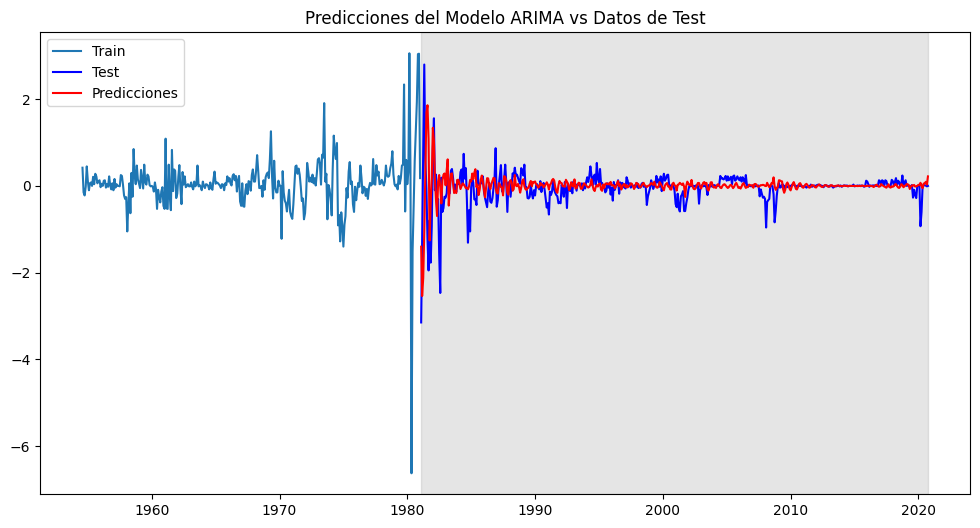

In [ ]:
# Visualización de las predicciones y los datos de prueba
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train,label='Train')
ax.plot(test, label='Test', color='blue')
ax.plot(st_pred_ARIMA, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo ARIMA vs Datos de Test')


fecha_inicio = test.index[0]
fecha_fin = test.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)


mse = mean_squared_error(test, st_pred_ARIMA)
rmse = np.sqrt(mse)

mse, rmse

## Tomado la serie y que el modelo  realice la diferenciaciòn

In [ ]:
# Separando la serie de tiempo diferenciada en conjuntos de entrenamiento y prueba
train_size = int(len(st) * 0.9)
train_st, test_st = st[:train_size], st[train_size:]

len(train_st), len(test_st)


(716, 80)

In [ ]:
ps = range(0, 10, 1)
qs = range(0, 10, 1)
d = 1

order_list = list(product(ps, qs))

result_df = optimize_ARIMA(train_st, order_list, d)
print(result_df)

  0%|          | 0/100 [00:00<?, ?it/s]

     (p,q)    AIC
0   (8, 9) 549.11
1   (2, 8) 554.73
2   (3, 8) 554.83
3   (2, 9) 555.41
4   (8, 3) 555.99
..     ...    ...
95  (1, 3) 580.72
96  (3, 1) 580.90
97  (1, 4) 581.02
98  (1, 6) 581.02
99  (0, 0) 620.26

[100 rows x 2 columns]


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  716
Model:                 ARIMA(2, 1, 8)   Log Likelihood                -448.414
Date:                Mon, 13 Nov 2023   AIC                            918.829
Time:                        20:53:59   BIC                            969.124
Sample:                    07-01-1954   HQIC                           938.251
                         - 02-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8062      0.061     13.166      0.000       0.686       0.926
ar.L2         -0.6875      0.042    -16.198      0.000      -0.771      -0.604
ma.L1         -0.4018      0.064     -6.249      0.0

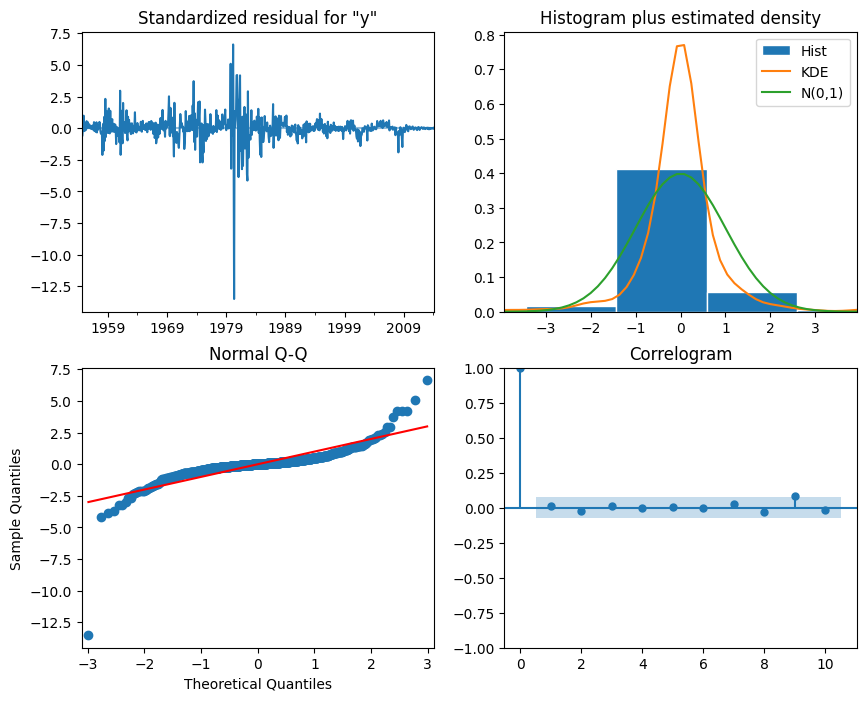

In [ ]:
# Ajustando el modelo ARIMA
model = ARIMA(train_st, order=(2, 1, 8))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(10,8));

In [ ]:
TRAIN_LEN = len(train_st)
HORIZON = len(test_st)
WINDOW = 1
pred_ARIMA_st = rolling_forecast(st, TRAIN_LEN, HORIZON, WINDOW, (2,1,8))
fechas = test_st.index
st_pred_ARIMA_st = pd.Series(pred_ARIMA_st[:len(fechas)], index=fechas)

mse = mean_squared_error(test_st, st_pred_ARIMA_st)
rmse = np.sqrt(mse)

mse, rmse



  0%|          | 0/80 [00:00<?, ?it/s]

(0.020162405102707382, 0.1419943840534103)

(0.19055350166673587, 0.43652434258210143)

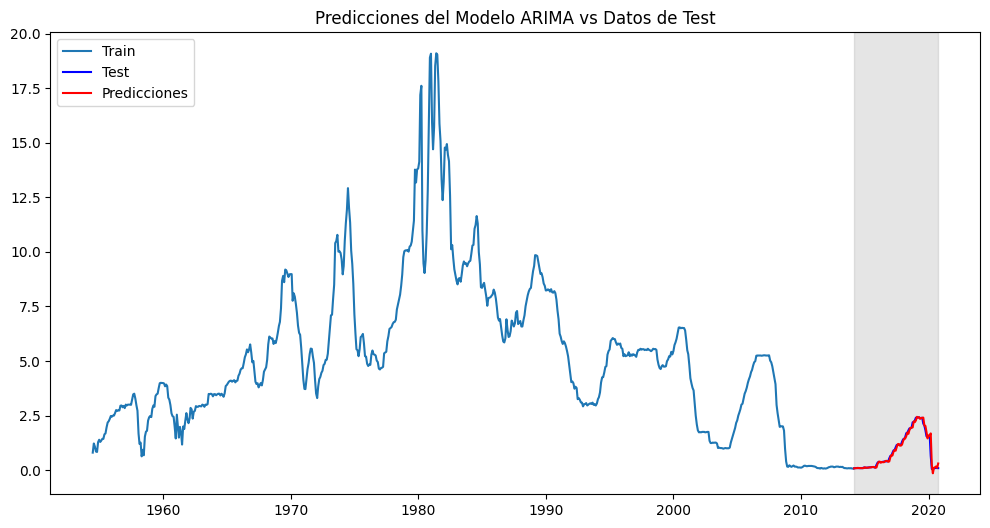

In [ ]:
# Visualización de las predicciones y los datos de prueba
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_st,label='Train')
ax.plot(test_st, label='Test', color='blue')
ax.plot(st_pred_ARIMA_st, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo ARIMA vs Datos de Test')


fecha_inicio = test_st.index[0]
fecha_fin = test_st.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)


mse = mean_squared_error(test, st_pred_ARIMA)
rmse = np.sqrt(mse)

mse, rmse

## Aplicando log

1 {'ADF Statistic': -18.25812133508875, 'p-value': 2.3345003520430944e-30, 'Critical Values': {'1%': -3.438623132449471, '5%': -2.8651915799370014, '10%': -2.568714441670417}, 'Is Stationary (p-value)': True, 'Is Stationary (ADF)': True, 'Is Stationary (Both)': True}


(318, 478)

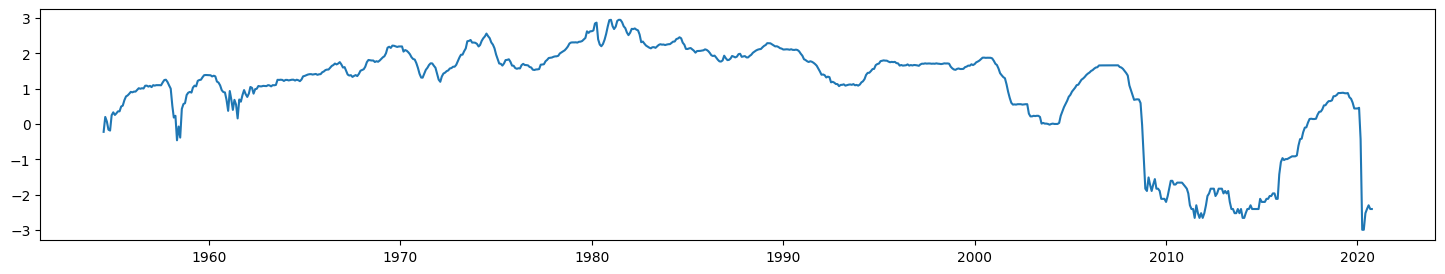

In [ ]:
st_log = np.log(st)
plt.plot(st_log)

d_count_log, diff_series_log, adf_results = make_stationary_recursive(st_log)

print(d_count_log,adf_results)

train_size = int(len(st) * 0.4)
train_st, test_st = st_log[:train_size], st_log[train_size:]

len(train_st), len(test_st)




                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  318
Model:                 ARIMA(2, 1, 8)   Log Likelihood                 218.447
Date:                Mon, 13 Nov 2023   AIC                           -414.893
Time:                        20:49:34   BIC                           -373.546
Sample:                    07-01-1954   HQIC                          -398.377
                         - 12-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7230      0.346      2.092      0.036       0.046       1.400
ar.L2         -0.5984      0.300     -1.997      0.046      -1.186      -0.011
ma.L1         -0.7853      0.346     -2.270      0.0

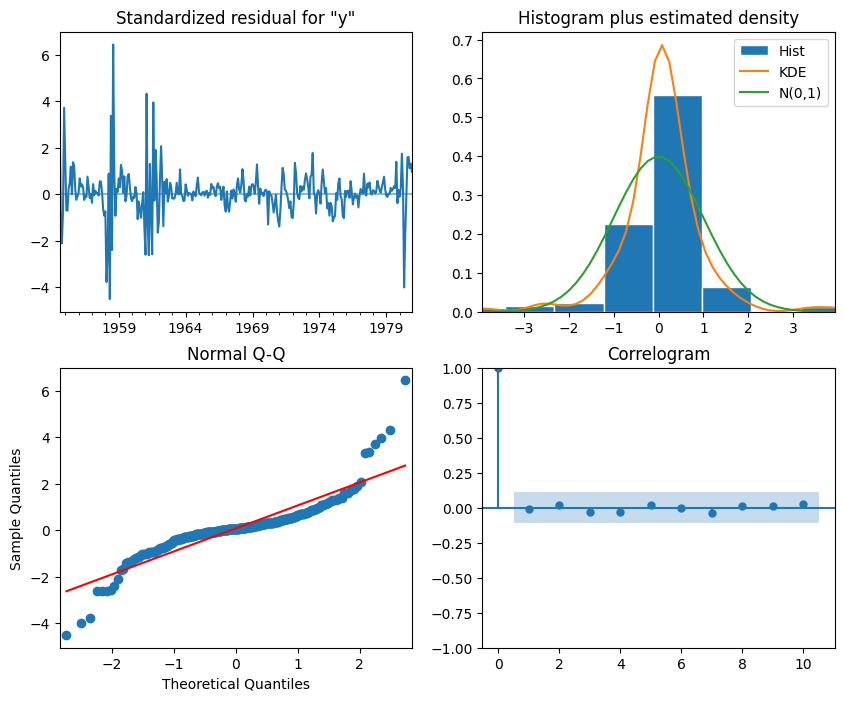

In [ ]:
# Ajustando el modelo ARIMA
model = ARIMA(train_st, order=(2, 1, 8))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(10,8));

In [ ]:
TRAIN_LEN = len(train_st)
HORIZON = len(test_st)
WINDOW = 8
pred_ARIMA_st = rolling_forecast(st_log, TRAIN_LEN, HORIZON, WINDOW, (2,1,8))
fechas = test_st.index
st_pred_ARIMA_st = pd.Series(pred_ARIMA_st[:len(fechas)], index=fechas)

mse = mean_squared_error(test_st, st_pred_ARIMA_st)
rmse = np.sqrt(mse)

mse, rmse


  0%|          | 0/60 [00:00<?, ?it/s]

(0.21505427516854855, 0.46373944750101703)

(0.020162405102707382, 0.1419943840534103)

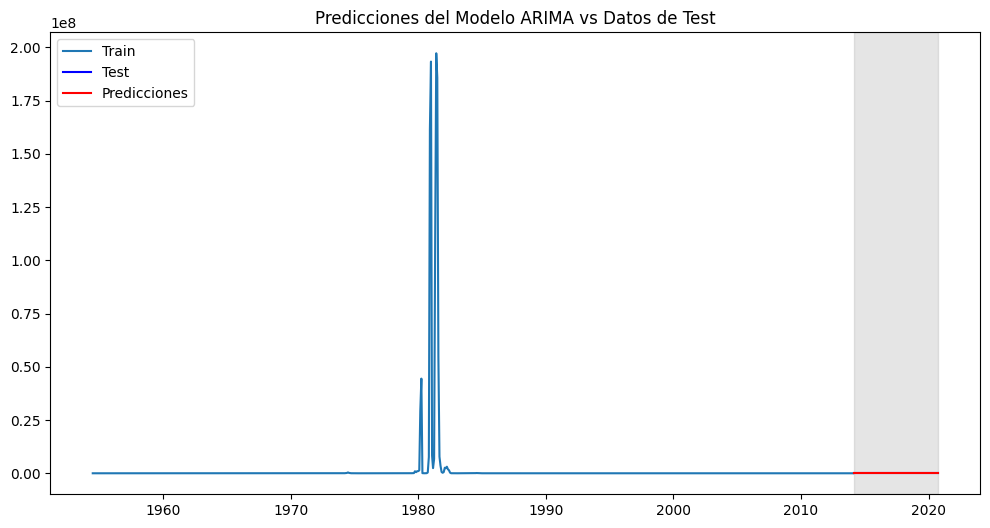

In [ ]:
# Visualización de las predicciones y los datos de prueba
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.exp(train_st),label='Train')
ax.plot(np.exp(test_st), label='Test', color='blue')
ax.plot(np.exp(st_pred_ARIMA_st), label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo ARIMA vs Datos de Test')


fecha_inicio = test_st.index[0]
fecha_fin = test_st.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)


mse = mean_squared_error(test_st, st_pred_ARIMA_st)
rmse = np.sqrt(mse)

mse, rmse

## Mejor modelo con Validación

In [ ]:
def evaluate_arima_model(df, train_len, horizon: int, window: int, order: list):

    test = df[train_len:]
    pred_ARIMA=rolling_forecast(df, train_len, horizon, window, order)
    rmse = np.sqrt(mean_squared_error(test, pred_ARIMA))
    return rmse


def evaluate_models(df, p_values, d_values, q_values):

    train_size = int(len(df) * 0.9)
    train, test = st[:train_size], st[train_size:]

    TRAIN_LEN = len(train)
    HORIZON = len(test)
    WINDOW = 1
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(df, TRAIN_LEN,HORIZON,WINDOW,order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue

    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
ps = [1, 2,8,9]
qs = [1,4,7,8]
ds  = [1, 2]
evaluate_models(st, ps, ds, qs)


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 0, 1) RMSE=0.135


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 0, 4) RMSE=0.136


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 0, 7) RMSE=0.140


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 0, 8) RMSE=0.141


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 0, 9) RMSE=0.141


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 0, 11) RMSE=0.145


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 1, 1) RMSE=0.130


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 1, 4) RMSE=0.133


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 1, 7) RMSE=0.138


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 1, 8) RMSE=0.139


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 1, 9) RMSE=0.138


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 1, 11) RMSE=0.138


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 2, 1) RMSE=0.132


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 2, 4) RMSE=0.130


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 2, 7) RMSE=0.136


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 2, 8) RMSE=0.136


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 2, 9) RMSE=0.138


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(1, 2, 11) RMSE=0.138


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 0, 1) RMSE=0.136


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 0, 4) RMSE=0.136


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 0, 7) RMSE=0.140


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 0, 8) RMSE=0.143


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 0, 9) RMSE=0.145


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 0, 11) RMSE=0.145


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 1, 1) RMSE=0.134


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 1, 4) RMSE=0.132


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 1, 7) RMSE=0.142


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 1, 8) RMSE=0.142


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 1, 9) RMSE=0.140


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 1, 11) RMSE=0.140


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 2, 1) RMSE=0.131


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 2, 4) RMSE=0.135


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 2, 7) RMSE=0.134


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 2, 8) RMSE=0.141


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 2, 9) RMSE=0.142


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 2, 11) RMSE=0.139


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 0, 1) RMSE=0.140


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 0, 4) RMSE=0.144


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 0, 7) RMSE=0.145


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 0, 8) RMSE=0.145


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 0, 9) RMSE=0.145


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 0, 11) RMSE=0.145


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 1, 1) RMSE=0.136


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 1, 4) RMSE=0.138


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 1, 7) RMSE=0.141


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 1, 8) RMSE=0.141


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 1, 9) RMSE=0.139


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 1, 11) RMSE=0.138


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 2, 1) RMSE=0.134


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 2, 4) RMSE=0.140


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 2, 7) RMSE=0.138


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 2, 8) RMSE=0.139


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 2, 9) RMSE=0.140


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(8, 2, 11) RMSE=0.140


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(9, 0, 1) RMSE=0.142


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(9, 0, 4) RMSE=0.143


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(9, 0, 7) RMSE=0.145


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(9, 0, 8) RMSE=0.144


  0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(9, 0, 9) RMSE=0.145


  0%|          | 0/80 [00:00<?, ?it/s]